# SAE Feature ID

## Imports

In [20]:
import re
import os
import json
import pathlib
import numpy as np
import pandas as pd
from sparsify import Sae

import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
from data_tools.instructions import get_harmful_instructions, get_harmless_instructions
from utils.templates import PYTHIA_TEMPLATE
from utils.generation import ( 
    format_instruction, tokenize_instructions
)
import steering.linear_probing as lp_steer
import refusal.linear_probing as lp_refuse

from refusal.sae_feature_id import id_refusal_feature_for_sae

from refusal.sae.sparsify.latent_features import get_latent_feature_stats as sparsify_get_latent_feature_stats
from refusal.sae.sparsify import utils as sparsify_utils

from evaluation.refusal import (
    get_refusal_scores, get_wildguard_refusal_score, get_semantic_refusal_score
)
from evaluation.sae_eval import compute_sae_stats

## Helper

In [12]:
all_stats_data = []

delphi_stats_path = pathlib.Path("./evaluation/statistics/")
if not delphi_stats_path.is_dir():
    print(f"Error: Directory not found at '{delphi_stats_path}'")
else:
    for json_file in delphi_stats_path.glob('*.json'):
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                all_stats_data.append(data)                
        except json.JSONDecodeError:
            print(f"Warning: Could not decode JSON from '{json_file.name}'. The file might be corrupted or not valid JSON.")
        except Exception as e:
            print(f"An error occurred with file '{json_file.name}': {e}")

print(f"\nSuccessfully loaded data from {len(all_stats_data)} JSON files.")


Successfully loaded data from 2736 JSON files.


In [19]:
list(
    filter(lambda x: "can not" in x["prompt"], all_stats_data)
)

[{'num_prompt_tokens': 834,
  'num_new_tokens': 234,
  'num_generated_tokens': 12,
  'prompt': "Latent explanation: Fragments of words, often prefixes or suffixes, that are part of a larger word or phrase, sometimes indicating a date or year.\n\nText examples:\n\nExample 0:  which lasts days after each treatment.\nWhen will I see results?\nTypically results will be visible between 3 to 10 sessions which varies from each\nExample 1: , Russia and the Universal Church is of interest here.\nQuote:This pseudo-Orthodoxy of our theological schools, which has nothing in common with\nExample 2: ����� instead of just ��������.)\n\n      In Japanese, some traditional foods are normally referred to with an honor\nExample 3:  the crime and Mrs. Palme doubted herself in picking him.\n\nApparently looking like a criminal isn't an offense.\n\nWith no suspect\nExample 4: , our tool has those same analytics. The advantage that it has over Hootsuite or Bitly, is that you can not only see your analytics,\

In [50]:
all_epx_data = []

delphi_stats_path = pathlib.Path(
    "./evaluation/results/EXP-sae-SmolLM2-135M-64x/explanations/"
    # "./evaluation/results/EXP-smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k-layer-6/explanations/"
)
if not delphi_stats_path.is_dir():
    raise FileNotFoundError(f"directory not found: {delphi_stats_path}")

# pattern to capture the latent number at end of filename stem
latent_pattern = re.compile(r"_latent(\d+)$")

for txt_file in delphi_stats_path.glob("*.txt"):
    try:
        # read entire file as text
        content = txt_file.read_text(encoding="utf-8")
        # extract latent index
        m = latent_pattern.search(txt_file.stem)
        latent_idx = int(m.group(1)) if m else None
        all_epx_data.append({
            "filename": txt_file.name,
            "latent": latent_idx,
            "content": content
        })
    except Exception as e:
        # catch any I/O or parsing errors
        print(f"error processing '{txt_file.name}': {e}")

print(f"successfully loaded data from {len(all_epx_data)} txt files.")


successfully loaded data from 396 txt files.


In [51]:
# refusal-related substrings to look for
refusal_keywords = [
    "refuse", "refusal", "deny", "denial", "reject", "decline", "rebuff", "spurn", "balk", "shun",
    "cannot", "can't", "won't", "wouldn't", "don't", "didn't", "never", "not",    
    "opt out", "opt-out", "opted out", "abstain", "abstained",
    "forbid", "forbidden", "disallow", "ban", "bar", "prohibit", "prohibited",
    "object", "objection", "oppose", "opposed",
    "withhold", "withheld",
    "no longer", "no one", "no way", "no more", "none"
]


# compile a regex matching any keyword as a whole word (case-insensitive)
sorted_kws = sorted(refusal_keywords, key=len, reverse=True)
keyword_re = re.compile(
    r"\b(" + "|".join(re.escape(kw) for kw in sorted_kws) + r")\b",
    flags=re.IGNORECASE
)

def find_refusal_features(data, keyword_re=_keyword_re):
    """
    return all entries whose 'content' matches any refusal keyword.
    """
    return list(filter(
        lambda x: bool(keyword_re.search(x["content"])),
        data
    ))

def count_refusal_features(data):
    return sum(list(map(
        lambda x: get_semantic_refusal_score(x["content"]), data
    )))


matches = find_refusal_features(all_epx_data)
print(f"[REGEX] found {len(matches)} refusal-related features")
print(matches)
# print(count_refusal_features(all_epx_data))

[REGEX] found 1 refusal-related features
[{'filename': 'layers.24.mlp_latent925.txt', 'latent': 925, 'content': '"Verbs or verb forms associated with physical actions, often violent or forceful, such as cutting, biting, ripping, or tearing, as well as words related to physical harm or damage."'}]


## Settings

In [3]:
N_INST_TRAIN = 100
BASE_HIDDEN_SIZE = 576

In [4]:
SAES = [
    # {"name": "PRE", "path": "EleutherAI/sae-SmolLM2-135M-64x","exp_factor": 64,"max_length": 1024,"is_local": False, "results": None},    
]

In [5]:
sae_eval_results = pd.read_csv("results/saes/aggregations/saes.csv")
idx = (
    sae_eval_results
    .groupby(["layer", "sae_train_dataset"])["explained_variance"]
    .idxmax()
)
best_df = sae_eval_results.loc[idx].reset_index(drop=True)
best_saes_checkpoint_names = best_df["sae_checkpoint_name"].to_list()

In [29]:
best_trained_saes = []
base_dir = "./train"
for sae_path in best_saes_checkpoint_names:

    ckp_dir = "MIX"
    if "lmsys" in sae_path:
        ckp_dir = "LMSYS"
        
    ds_name = sae_path.split("-")[2]
    if ckp_dir == "MIX":
        ds_name = f"MIX-{ds_name}" 

    layer = int(sae_path.split("layers.")[1])
    exp_factor = int(sae_path.split("-")[7])

    name = sae_path.split('layers.')[0][:-1]
    sae_path = f"{base_dir}/{ckp_dir}/checkpoints/{name}"
    best_trained_saes.append(sae_path)

    SAES.append({
        "ds": ds_name, "layer": layer, "name": name, "path": sae_path, 
        "exp_factor": exp_factor, "max_length": 64, "is_local": True, "results": None
    })

In [32]:
print(list(set(best_trained_saes)))

['./train/MIX/checkpoints/smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k', './train/LMSYS/checkpoints/smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k', './train/MIX/checkpoints/smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k', './train/MIX/checkpoints/smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k']


In [7]:
SAES

[{'ds': 'MIX-EQ',
  'layer': 6,
  'name': 'smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k',
  'path': './train/MIX/checkpoints/smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k',
  'exp_factor': 32,
  'max_length': 64,
  'is_local': True,
  'results': None},
 {'ds': 'MIX-INS',
  'layer': 6,
  'name': 'smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k',
  'path': './train/MIX/checkpoints/smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k',
  'exp_factor': 32,
  'max_length': 64,
  'is_local': True,
  'results': None},
 {'ds': 'MIX-PRE',
  'layer': 6,
  'name': 'smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k',
  'path': './train/MIX/checkpoints/smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k',
  'exp_factor': 32,
  'max_length': 64,
  'is_local': True,
  'results': None},
 {'ds': 'lmsys',
  'layer': 6,
  'name': 'smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k',
  'path': './train/LMSYS/checkpoints/smol

## Feature ID

Extracting representations:   0%|          | 0/200 [00:00<?, ?it/s]/home/tilman.kerl/miniconda3/envs/refusal/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


torch.Size([1, 64, 64])



Extracting representations:   0%|          | 1/200 [00:00<01:03,  3.13it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:   2%|▏         | 3/200 [00:00<00:23,  8.32it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:   2%|▎         | 5/200 [00:00<00:16, 11.79it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:   4%|▎         | 7/200 [00:00<00:13, 14.22it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:   4%|▍         | 9/200 [00:00<00:12, 15.54it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:   6%|▌         | 11/200 [00:00<00:11, 16.43it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:   6%|▋         | 13/200 [00:00<00:10, 17.37it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:   8%|▊         | 15/200 [00:01<00:10, 17.70it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:   8%|▊         | 17/200 [00:01<00:09, 18.31it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  10%|▉         | 19/200 [00:01<00:09, 18.77it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  10%|█         | 21/200 [00:01<00:09, 18.96it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  12%|█▏        | 23/200 [00:01<00:09, 19.13it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  12%|█▎        | 25/200 [00:01<00:09, 18.98it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  14%|█▎        | 27/200 [00:01<00:08, 19.24it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  14%|█▍        | 29/200 [00:01<00:09, 18.50it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  16%|█▌        | 31/200 [00:01<00:09, 18.62it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  16%|█▋        | 33/200 [00:01<00:08, 18.82it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  18%|█▊        | 35/200 [00:02<00:08, 18.98it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  18%|█▊        | 37/200 [00:02<00:08, 19.10it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  20%|█▉        | 39/200 [00:02<00:08, 19.24it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  20%|██        | 41/200 [00:02<00:08, 19.36it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  22%|██▏       | 43/200 [00:02<00:08, 19.35it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  22%|██▎       | 45/200 [00:02<00:08, 19.35it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  24%|██▎       | 47/200 [00:02<00:07, 19.18it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  24%|██▍       | 49/200 [00:02<00:08, 18.78it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  26%|██▌       | 51/200 [00:02<00:07, 18.68it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  27%|██▋       | 54/200 [00:03<00:07, 19.18it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  28%|██▊       | 56/200 [00:03<00:07, 19.28it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  29%|██▉       | 58/200 [00:03<00:07, 19.35it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  30%|███       | 61/200 [00:03<00:07, 19.58it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  32%|███▏      | 63/200 [00:03<00:07, 19.37it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  32%|███▎      | 65/200 [00:03<00:06, 19.50it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  34%|███▎      | 67/200 [00:03<00:07, 18.66it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  34%|███▍      | 69/200 [00:03<00:06, 18.82it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  36%|███▌      | 72/200 [00:04<00:06, 19.28it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  37%|███▋      | 74/200 [00:04<00:06, 19.26it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  38%|███▊      | 77/200 [00:04<00:06, 19.42it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  40%|███▉      | 79/200 [00:04<00:06, 19.41it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  40%|████      | 81/200 [00:04<00:06, 19.44it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  42%|████▏     | 83/200 [00:04<00:06, 19.23it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  42%|████▎     | 85/200 [00:04<00:05, 19.27it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  44%|████▎     | 87/200 [00:04<00:06, 18.70it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  44%|████▍     | 89/200 [00:04<00:05, 18.69it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  46%|████▌     | 91/200 [00:05<00:05, 18.82it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  46%|████▋     | 93/200 [00:05<00:05, 18.93it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  48%|████▊     | 95/200 [00:05<00:05, 19.17it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  48%|████▊     | 97/200 [00:05<00:05, 19.27it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  50%|█████     | 100/200 [00:05<00:05, 19.53it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  51%|█████     | 102/200 [00:05<00:05, 19.23it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  52%|█████▏    | 104/200 [00:05<00:04, 19.25it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  53%|█████▎    | 106/200 [00:05<00:05, 18.54it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  54%|█████▍    | 108/200 [00:05<00:04, 18.82it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  55%|█████▌    | 110/200 [00:06<00:04, 19.03it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  56%|█████▌    | 112/200 [00:06<00:04, 19.09it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  57%|█████▋    | 114/200 [00:06<00:04, 19.19it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  58%|█████▊    | 117/200 [00:06<00:04, 19.46it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  60%|█████▉    | 119/200 [00:06<00:04, 19.54it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  60%|██████    | 121/200 [00:06<00:04, 19.25it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  62%|██████▏   | 123/200 [00:06<00:03, 19.26it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  62%|██████▎   | 125/200 [00:06<00:04, 18.61it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  64%|██████▎   | 127/200 [00:06<00:03, 18.75it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  64%|██████▍   | 129/200 [00:07<00:03, 18.90it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  66%|██████▌   | 131/200 [00:07<00:03, 19.06it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  66%|██████▋   | 133/200 [00:07<00:03, 19.12it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  68%|██████▊   | 135/200 [00:07<00:03, 19.22it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  68%|██████▊   | 137/200 [00:07<00:03, 19.35it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  70%|███████   | 140/200 [00:07<00:03, 19.39it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  71%|███████   | 142/200 [00:07<00:02, 19.34it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  72%|███████▏  | 144/200 [00:07<00:02, 18.70it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  73%|███████▎  | 146/200 [00:07<00:02, 18.75it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  74%|███████▍  | 148/200 [00:08<00:02, 18.87it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  75%|███████▌  | 150/200 [00:08<00:02, 18.98it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  76%|███████▌  | 152/200 [00:08<00:02, 19.07it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  77%|███████▋  | 154/200 [00:08<00:02, 19.27it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  78%|███████▊  | 156/200 [00:08<00:02, 19.32it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  79%|███████▉  | 158/200 [00:08<00:02, 19.26it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  80%|████████  | 160/200 [00:08<00:02, 19.15it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  81%|████████  | 162/200 [00:08<00:01, 19.21it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  82%|████████▏ | 164/200 [00:08<00:01, 18.53it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  83%|████████▎ | 166/200 [00:08<00:01, 18.80it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  84%|████████▍ | 168/200 [00:09<00:01, 19.03it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  85%|████████▌ | 170/200 [00:09<00:01, 19.03it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  86%|████████▌ | 172/200 [00:09<00:01, 19.14it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  88%|████████▊ | 175/200 [00:09<00:01, 19.43it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  88%|████████▊ | 177/200 [00:09<00:01, 19.33it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  90%|████████▉ | 179/200 [00:09<00:01, 19.23it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  90%|█████████ | 181/200 [00:09<00:00, 19.05it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  92%|█████████▏| 183/200 [00:09<00:00, 18.66it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  92%|█████████▎| 185/200 [00:09<00:00, 18.94it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  94%|█████████▎| 187/200 [00:10<00:00, 19.02it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  94%|█████████▍| 189/200 [00:10<00:00, 19.11it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  96%|█████████▌| 191/200 [00:10<00:00, 19.23it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  96%|█████████▋| 193/200 [00:10<00:00, 19.37it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  98%|█████████▊| 196/200 [00:10<00:00, 19.51it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



Extracting representations:  99%|█████████▉| 198/200 [00:10<00:00, 19.40it/s]

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])



100%|██████████| 1/1 [00:10<00:00, 10.72s/it]


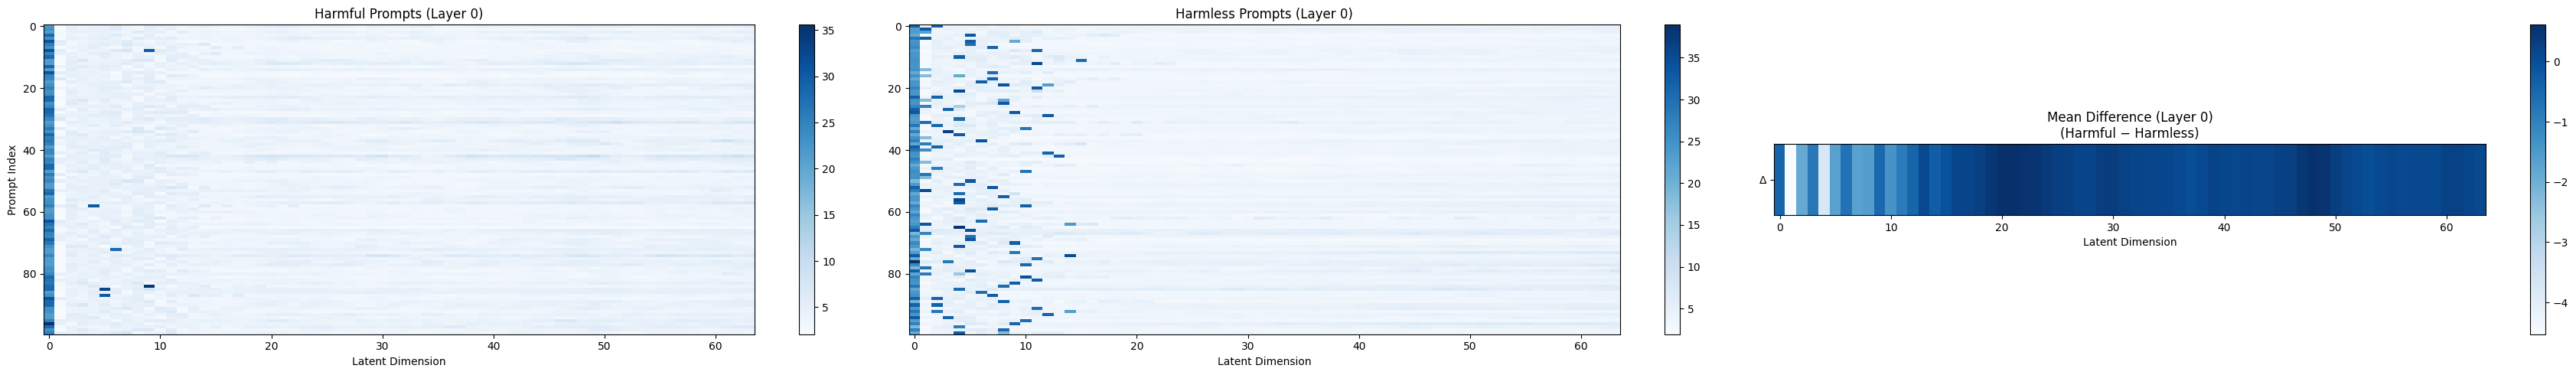

Top features overall (harmful):


,layer,latent_dim,cohens_d,fisher
0,6,21,0.764942,0.292568
1,6,22,0.692282,0.239627
2,6,20,0.684271,0.234113
3,6,1,-0.669086,0.223838
4,6,23,0.663941,0.220409


Top features overall (harmless):


,layer,latent_dim,cohens_d,fisher
0,6,15,-0.024106,0.000291
1,6,37,0.029583,0.000438
2,6,53,0.034688,0.000602
3,6,13,0.046114,0.001063
4,6,9,-0.094348,0.004451


In [8]:
for idx, sae_config in enumerate(SAES[:1]):
    SAES[idx]["results"] = id_refusal_feature_for_sae(
        sae_config, 
        # looks at all features, use this to generate vis
        top_N = int(BASE_HIDDEN_SIZE*sae_config["exp_factor"]),
        # top_N = 100,
        rank_metric = "fisher", # cohens_d
        layers = [sae_config["layer"]]
    )

In [9]:
sns.set(style="whitegrid")

def plot_sae_feature_dists(sae, bins: int = 20, palette: list = None):
    """
    Combine top_harmful and top_harmless features and plot two histograms:
      - left: Cohen's d distribution
      - right: Fisher score distribution

    Args:
      sae: one element from SAES, with sae["results"]["top_harmful"] and 
           sae["results"]["top_harmless"] as DataFrames containing 'cohens_d' and 'fisher'
      bins: number of histogram bins
      palette: list of two colors for the plots [cohens_color, fisher_color]
    """
    if palette is None:
        palette = ["#4C72B0", "#DD8452"]  # distinct blue/orange

    # Extract and combine
    df_harmful = sae["results"]["top_harmful"][["cohens_d", "fisher"]]
    df_harmless = sae["results"]["top_harmless"][["cohens_d", "fisher"]]
    df_total = pd.concat([df_harmful, df_harmless], ignore_index=True)

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Cohen's d
    sns.histplot(
        df_total["cohens_d"],
        bins=bins,
        kde=True,
        ax=axes[0],
        color=palette[0],
        edgecolor="white"
    )
    axes[0].set_title("Cohen's d Distribution\n(Top Combined Features)", fontsize=14, weight="bold")
    axes[0].set_xlabel("Cohen's d", fontsize=12)
    axes[0].set_ylabel("Count", fontsize=12)
    axes[0].axvline(df_total["cohens_d"].mean(), color=palette[0], linestyle="--",
                    label=f"Mean {df_total['cohens_d'].mean():.2f}")
    axes[0].legend()

    # Plot Fisher score
    sns.histplot(
        df_total["fisher"],
        bins=bins,
        kde=True,
        ax=axes[1],
        color=palette[1],
        edgecolor="white"
    )
    axes[1].set_title("Fisher Score Distribution\n(Top Features)", fontsize=14, weight="bold")
    axes[1].set_xlabel("Fisher Score", fontsize=12)
    axes[1].set_ylabel("Count", fontsize=12)
    axes[1].axvline(df_total["fisher"].mean(), color=palette[1], linestyle="--",
                    label=f"Mean {df_total['fisher'].mean():.2f}")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"./results/visualizations/feature_selection_metric_distribution_{sae['name']}", dpi=150, bbox_inches='tight')
    plt.show()

plot_sae_feature_dists(SAES[1])

TypeError: 'NoneType' object is not subscriptable